In [38]:
import pandas as pd

# 读取CSV文件
file_path = 'data/overall/btc (1).csv'  # 替换为你的CSV文件路径
df = pd.read_csv(file_path)

# 为数据集添加列名
columns = ['OpenTime', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseTime', 
           'QuoteAssetVolume', 'NumberOfTrades', 'TakerBuyBaseAssetVolume', 
           'TakerBuyQuoteAssetVolume', 'Ignore']
df.columns = columns

# 计算涨幅百分比
df['Change'] = ((df['Close'] - df['Open']) / df['Open']) * 100

# 计算HighChange
df['HighChange'] = ((df['High'] - df['Close']) / df['Close']) * 100

# 计算LowChange
df['LowChange'] = ((df['Low'] - df['Close']) / df['Close']) * 100

# 计算VolChange
df['VolumeChange'] = df['Volume'].diff()
df.loc[df.index[0], 'VolumeChange'] = 0

# 计算这些差异的百分比，并在Volume为0时将VolChange设置为0
# 先计算差异的百分比
df['VolChange'] = ((df['VolumeChange'] / df['Volume'].shift(1)) * 100)
# 将Volume为0的行的VolChange设置为0
df.loc[df['Volume'].shift(1) == 0, 'VolChange'] = 0
# 替换任何NaN值为0
df['VolChange'] = df['VolChange'].fillna(0)

# 计算SD Upper和SD Lower
sdwindow = 14
std_dev = df['Close'].rolling(window=sdwindow).std()
df['sdupper'] = df['Close'] + 2 * std_dev
df['sdlower'] = df['Close'] - 2 * std_dev

# 计算5周期EMA
emawindow=5
df['ema5'] = df['Close'].ewm(span=emawindow, adjust=False).mean()

# 计算14周期RSI
delta = df['Close'].diff()
rsiwindow=14
gain = (delta.where(delta > 0, 0)).rolling(window=rsiwindow).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=rsiwindow).mean()
RS = gain / loss
df['RSI'] = 100 - (100 / (1 + RS))

# 移除第x行，因为它包含了NaN值
skip=max(rsiwindow,sdwindow,emawindow)
df = df.iloc[skip:]

# 保存到新的CSV文件（如果需要）
output_file_path = 'Processed_Data/overall/BTC.csv'  # 替换为你要保存的文件路径
df.to_csv(output_file_path, index=False)


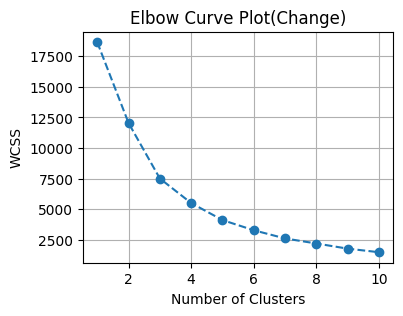

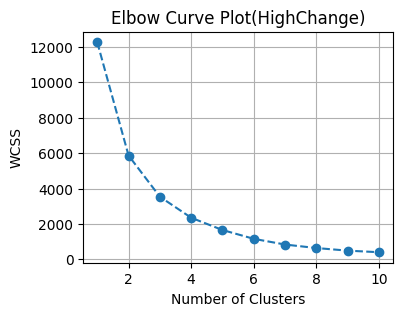

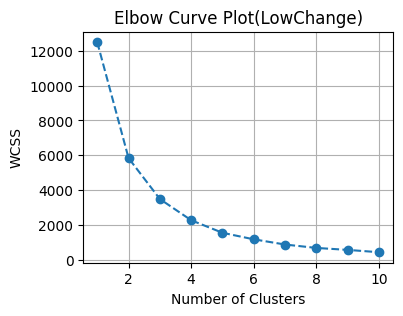

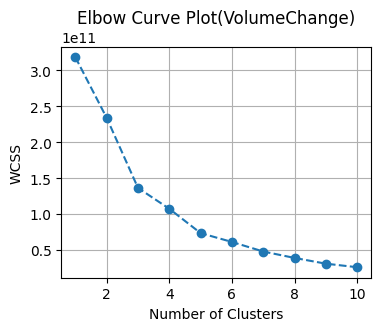

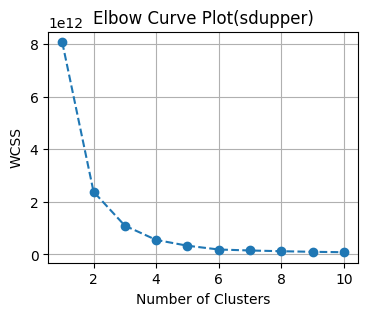

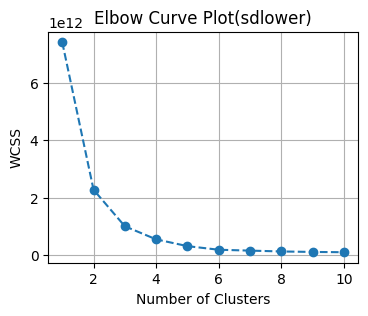

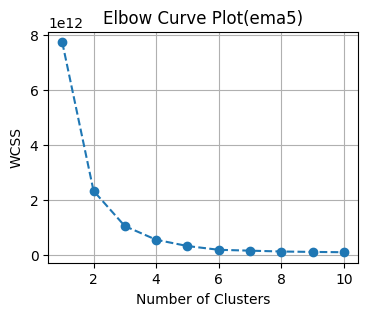

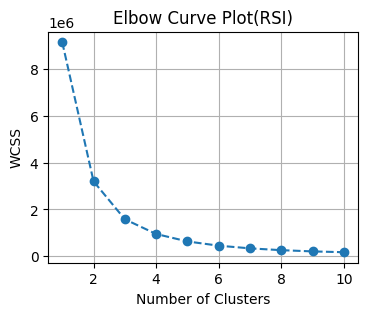

                min        max
cluster1                      
0        -18.220147  -0.652625
1          0.604302  17.367225
2         -0.652412   0.604173
               min        max
cluster2                     
0         0.708734   2.383526
1         0.000000   0.708314
2         2.385472  22.479675
                min       max
cluster3                     
0         -0.720924  0.000000
1         -2.284920 -0.720948
2        -21.997191 -2.293913
                   min           max
cluster4                            
0          -100.000000     98.946986
1         15530.844344  15530.844344
2            99.042356   2454.939637
                   min           max
cluster5                            
0         22264.035649  41322.635882
1          5142.814008  22260.708103
2         41324.948673  70482.724562
                   min           max
cluster6                            
0         21716.139924  40081.257930
1          2837.234258  21713.509998
2         40083.643029  674

In [39]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 读取CSV文件
file_path = 'Processed_Data/overall/BTC.csv'
df = pd.read_csv(file_path)

# 定义一个函数来执行KMeans聚类和绘制肘部图表
def plot_elbow(feature_col):
    # 使用KMeans的肘部法则来确定最佳的簇数
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(pd.DataFrame(feature_col))
        wcss.append(kmeans.inertia_)

    # 绘制肘部图表
    plt.figure(figsize=(4, 3))
    plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
    plt.title(f'Elbow Curve Plot({feature_col.name})')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.grid(True)
    plt.show()

# 应用聚类函数
for feature in ['Change', 'HighChange', 'LowChange', 'VolumeChange','sdupper','sdlower','ema5','RSI']:
    plot_elbow(df[feature])

# 根据肘部图表选择最佳的簇数，然后进行聚类
optimal_clusters = 3 
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster1'] = kmeans.fit_predict(df[['Change']])

# 找到每个簇的涨幅范围
cluster_ranges1 = df.groupby('cluster1')['Change'].agg(['min', 'max'])

# 打印每个簇的涨幅范围
print(cluster_ranges1)

# 根据肘部图表选择最佳的簇数，然后进行聚类
optimal_clusters = 3 
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster2'] = kmeans.fit_predict(df[['HighChange']])

# 找到每个簇的涨幅范围
cluster_ranges2 = df.groupby('cluster2')['HighChange'].agg(['min', 'max'])

# 打印每个簇的涨幅范围
print(cluster_ranges2)

# 根据肘部图表选择最佳的簇数，然后进行聚类
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster3'] = kmeans.fit_predict(df[['LowChange']])

# 找到每个簇的涨幅范围
cluster_ranges3 = df.groupby('cluster3')['LowChange'].agg(['min', 'max'])

# 打印每个簇的涨幅范围
print(cluster_ranges3)

# 根据肘部图表选择最佳的簇数，然后进行聚类
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster4'] = kmeans.fit_predict(df[['VolChange']])

# 找到每个簇的涨幅范围
cluster_ranges4 = df.groupby('cluster4')['VolChange'].agg(['min', 'max'])

# 打印每个簇的涨幅范围
print(cluster_ranges4)

# 根据肘部图表选择最佳的簇数，然后进行聚类
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster5'] = kmeans.fit_predict(df[['sdupper']])

# 找到每个簇的涨幅范围
cluster_ranges5 = df.groupby('cluster5')['sdupper'].agg(['min', 'max'])

# 打印每个簇的涨幅范围
print(cluster_ranges5)

# 根据肘部图表选择最佳的簇数，然后进行聚类
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster6'] = kmeans.fit_predict(df[['sdlower']])

# 找到每个簇的涨幅范围
cluster_ranges6 = df.groupby('cluster6')['sdlower'].agg(['min', 'max'])

# 打印每个簇的涨幅范围
print(cluster_ranges6)

# 根据肘部图表选择最佳的簇数，然后进行聚类
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster7'] = kmeans.fit_predict(df[['ema5']])

# 找到每个簇的涨幅范围
cluster_ranges7 = df.groupby('cluster7')['ema5'].agg(['min', 'max'])

# 打印每个簇的涨幅范围
print(cluster_ranges7)

# 根据肘部图表选择最佳的簇数，然后进行聚类
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster8'] = kmeans.fit_predict(df[['RSI']])

# 找到每个簇的涨幅范围
cluster_ranges8 = df.groupby('cluster8')['RSI'].agg(['min', 'max'])

# 打印每个簇的涨幅范围
print(cluster_ranges8)


# 保存到新的CSV文件
output_file_path = 'Processed_Data/overall/BTC_clustered.csv'
df.to_csv(output_file_path, index=False)



In [44]:
import pandas as pd

# 读取CSV文件
file_path = 'Processed_Data/overall/BTC_clustered.csv'  # 替换为你的CSV文件路径
df = pd.read_csv(file_path)

# 创建一个映射字典
recode_dict1 = {1: 'high', 0: 'normal', 2: 'low'}
recode_dict2 = {2: 'high', 1: 'normal', 0: 'low'}
recode_dict3 = {0: 'high', 2: 'normal', 1: 'low'}
recode_dict4 = {1: 'high', 2: 'normal', 0: 'low'}

recode_dict5 = {2: 'high', 0: 'normal', 1: 'low'}
recode_dict6 = {2: 'high', 0: 'normal', 1: 'low'}
recode_dict7 = {2: 'high', 0: 'normal', 1: 'low'}
recode_dict8 = {2: 'high', 0: 'normal', 1: 'low'}

# 应用映射到每一列
recode_dicts = [recode_dict1, recode_dict2, recode_dict3, recode_dict4, recode_dict5, recode_dict6, recode_dict7, recode_dict8]

# 使用 for 循环为每个列应用映射
for i, recode_dict in enumerate(recode_dicts, start=1):
    column_name = f'cluster{i}'
    df[column_name] = df[column_name].apply(lambda x: recode_dict[x] if x in recode_dict else x)


# 创建一个映射字典
fct_recode= {'high':3, 'normal':2, 'low':1}

#重命名新创建的列
df.rename(columns={'cluster1': 'changecluster', 'cluster2': 'highcluster', 'cluster3': 'lowcluster', 'cluster4': 'volcluster',
                   'cluster5': 'sdupcluster', 'cluster6': 'sdlowcluster', 'cluster7': 'ema5cluster', 'cluster8': 'rsicluster'}, inplace=True)


# 定义映射字典
fct_recode = {'high': 3, 'normal': 2, 'low': 1}

# 应用映射到列名
df.rename(columns=fct_recode, inplace=True)

# 应用映射到列内容
for col in ['changecluster', 'highcluster', 'lowcluster', 'volcluster', 'sdupcluster', 'sdlowcluster', 'ema5cluster', 'rsicluster']:
    df[col] = df[col].map(fct_recode)

# 更新CSV文件
output_file_path = 'Processed_Data/overall/BTC_renamed.csv'  
df.to_csv(output_file_path, index=False)


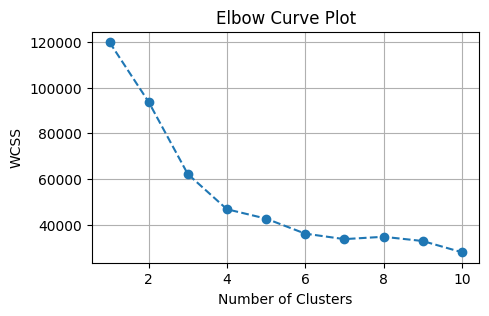

        changecluster     highcluster     lowcluster     volcluster      \
                  min max         min max        min max        min max   
cluster                                                                   
0                   1   3           1   3          2   3          1   2   
1                   1   3           1   3          1   3          1   2   
2                   1   3           1   3          1   3          1   2   
3                   1   3           1   3          1   3          1   3   

        sdupcluster     sdlowcluster     ema5cluster     rsicluster      
                min max          min max         min max        min max  
cluster                                                                  
0                 1   3            1   3           1   3          1   3  
1                 2   3            2   3           2   3          1   3  
2                 1   2            1   2           1   2          1   3  
3                 1   3       

In [47]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 读取CSV文件
file_path = 'Processed_Data/overall/BTC_renamed.csv'
df = pd.read_csv(file_path)

# 进行 K-Means 聚类
# 选择聚类特征列
feature_columns = ['changecluster', 'highcluster', 'lowcluster', 'volcluster', 'sdupcluster', 'sdlowcluster', 'ema5cluster', 'rsicluster']

# 使用KMeans的肘部法则来确定最佳的簇数
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df[feature_columns])
    wcss.append(kmeans.inertia_)

# 绘制肘部图表
plt.figure(figsize=(5, 3))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Curve Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# 根据肘部图表选择最佳的簇数，然后进行聚类
optimal_clusters = 4 
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
df['cluster'] = kmeans.fit_predict(df[feature_columns])

# 找到每个簇的涨幅范围
cluster_ranges = df.groupby('cluster')[feature_columns].agg(['min', 'max'])

# 打印每个簇的涨幅范围
print(cluster_ranges)

# 保存到新的CSV文件
output_file_path = 'Processed_Data/overall/BTC_ready.csv'
df.to_csv(output_file_path, index=False)
